# Back propagation neural network 
This notebooks contains the code used to create a dense neural network with one input layer, one hidden layer and one output layer. The number of neurons in the hidden layer is calculated by 
- neurons_hidden_layer = (1/2)(neuros_input_layer + neurons_output_layer)
{Acoording to documentation in Neurshell - software used in original paper}

The implementation of this notebook is based on (Wei, Yu. and Chen, Mu-Chen, 2012) - Forecasting the short-term metro passenger flow with empirical mode decomposition and neural networks. Transportation Research Part C. 


In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
import json

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings('ignore')

## Load data

In [ ]:
## Load the data 
input_path = 'data/'
df = pd.read_csv(input_path + 'clean_transactions.csv', parse_dates = ['timestamp'])

## Transform the data 
transactions = df.copy()
station_cols = transactions.columns[~transactions.columns.str.contains('time')]
transactions[station_cols] = transactions[station_cols] + 1
transactions[station_cols] = transactions[station_cols].transform(np.log)

#Adding more variables
transactions['day'] = transactions.timestamp.dt.dayofweek 
transactions['hour'] = transactions.timestamp.dt.hour 
transactions['weekday'] = (transactions.day <= 4).astype(int)

## Split the data 
def split_data(df):
    n = len(df)
    train_df = df[0:126646]
    test_df = df[126646:149790]
    covid_df = df[149790:]
    return train_df, test_df, covid_df
train_df, test_df, covid_df = split_data(transactions.set_index('timestamp'))

## Helper functions

In [ ]:
#######################
## Window generation ##
#######################

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, test_df=test_df, covid_df=covid_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.test_df = test_df
        self.covid_df = covid_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                            enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

## adding functions to Window generation class 
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col = '(02000) Cabecera Autopista Norte', max_subplots=3, 
        xlabel = 'Time [h]'):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel(xlabel)

WindowGenerator.plot = plot

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=128,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def covid(self):
  return self.make_dataset(self.covid_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.test = test
WindowGenerator.covid = covid
WindowGenerator.example = example

In [ ]:
#################################################
## This compalies and fit any model in general ##
#################################################
MAX_EPOCHS = 20
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                         tf.metrics.RootMeanSquaredError()]) ## this is where I could potentially change the metric 

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.test,
                      callbacks=[early_stopping])
  return history

In [ ]:
##############################
## Run multiple simulations ##
##############################
def nn_model(input_width=6, label_width=4, shift= 4, num_features = 1, 
             train_df = train, test_df = test, covid_df = covid, column = '(02000) Cabecera Autopista Norte'):

    ## Create windowing:
    window = WindowGenerator(input_width=input_width, 
                              label_width=label_width, 
                              shift=shift,
                              train_df=train_df, 
                              test_df=test_df, 
                              covid_df=covid_df,
                              label_columns=[column])

    units_layer = int(0.5*(input_width + shift))
    ## Create neural network structure: 
    if shift == 1: 
        neural_net = tf.keras.Sequential([
            tf.keras.layers.Flatten(),#Input layaer
            tf.keras.layers.Dense(units=units_layer, activation='sigmoid'),#Hidden layer
            tf.keras.layers.Dense(units=shift),#Output layer
            tf.keras.layers.Reshape([1, -1]),
            ])
    elif shift > 1: 
        neural_net = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, 1, features]
            tf.keras.layers.Lambda(lambda x: x[:, -1:, :]), #input Layer
            # Shape => [batch, 1, dense_units]
            tf.keras.layers.Dense(units_layer, activation='sigmoid'), # Hidden layer
            # Shape => [batch, 1, out_step]
            tf.keras.layers.Dense(shift), # Output Layer
            # Shape => [batch, out_steps, 1]
            tf.keras.layers.Reshape([shift, -1])
            ])
    else:
        raise "Predicte time steps should be a positive integer number"


    model = compile_and_fit(neural_net, window)
    return model, window, neural_net


## New data data organization 


In [3]:
def data_generation(df, ts_cols, os_cols, y = None, steps_back = 6, steps_future = 4, 
                    train_date = '2019-06-01', post_covid_date = '2020-03-01'):
    '''
    Parameters
    ------------
    df: Pandas dataframe with data 
    ts_cols: time series columns 
    os_cols: one timestep columns
    y: dependent variable
    steps_back = time steps for time series columns
    steps_future: forecast prediciton period'''

    ## Window handling 
    column_indices = {name: i for i, name in enumerate(df.columns)}
    ts_idx = [column_indices[key] for key in ts_cols]
    os_idx = [column_indices[key] for key in os_cols]

    if y is None:
        not_station_cols = ts_cols + os_cols + ['timestamp']
        y = df.columns[~df.columns.isin(not_station_cols)]
        y_idx = [column_indices[key] for key in y]
    
    else: 
        y_idx = [column_indices[key] for key in y]
    
    assert len(y) == 1

    x = np.array(df)
    data_points = df.shape[0] - steps_back - steps_future + 1

    def partition(x, i):
        ts_slide = slice(i, i + steps_back)
        os_slide = slice(i + steps_back, i + steps_back + 1)
        y_slide = slice(i + steps_back, i + steps_back + steps_future)

        ts = x[ts_slide,ts_idx].flatten(order = 'F')
        os = x[os_slide,os_idx].flatten()
        inputs = np.hstack((ts,os))
        
        target = x[y_slide,y_idx].flatten()
        return inputs, target

    results = np.array([partition(x, i) for i in range(data_points)])

    inputs = np.stack(results[:,0]).astype('float32')
    target = np.stack(results[:,1]).astype('float32')
    dataset = tf.data.Dataset.from_tensor_slices((inputs,target))

    train_value = df[df.timestamp == train_date].index[0] - steps_back
    pre_value = df[df.timestamp == post_covid_date].index[0] - train_value - steps_back

    train = dataset.take(train_value)
    pre = dataset.skip(train_value).take(pre_value)
    post = dataset.skip(train_value + pre_value)
    del (dataset)
    return train, pre, post, y[0]


In [4]:
def compile_and_fit(train_df, batch_size = 128):
    for feat, targ in train_df.take(1):
        input_layer = feat.shape[0]
        target_layer = targ.shape[0]
        hidden_neurons = int((input_layer + target_layer)/2)

    neural_net = tf.keras.Sequential([
                 tf.keras.layers.Dense(hidden_neurons, activation='sigmoid'), # Hidden layer
                 tf.keras.layers.Dense(target_layer)])

    neural_net.compile(loss=tf.losses.MeanSquaredError(),
                       optimizer=tf.optimizers.Adam(),
                       metrics=[tf.keras.metrics.MeanAbsoluteError(),  
                                tf.metrics.RootMeanSquaredError()])

    train_dataset = train_df.batch(batch_size, num_parallel_calls = 3)
    neural_net.fit(train_dataset, epochs=30)
    IPython.display.clear_output()
    
    return neural_net

In [46]:
def predict_and_store(model, station, pre_df, post_df, batch_size = 128):
    pre = pre_df.batch(batch_size, num_parallel_calls = 3)
    post = post_df.batch(batch_size, num_parallel_calls = 3)

    station_dict = {}
    station_dict['name'] = station

    station_dict['pre_predict'] = model.predict(pre).tolist()
    station_dict['post_predict'] = model.predict(post).tolist()
    
    pre_target = np.vstack(list(map(lambda x: x[1], pre))).tolist()
    post_target = np.vstack(list(map(lambda x: x[1], post))).tolist()

    station_dict['pre_target'] = pre_target
    station_dict['post_target'] = post_target
 

    # results_dict[station] = station_dict
    print ('Station ', station, 'run succesfully' )
    return station_dict


In [47]:
def save_json(path, dictionary):
    a_file = open(path, "w")
    json.dump(dictionary, a_file)
    a_file.close()

In [28]:
data = pd.read_csv('data/EDM/(02000) Cabecera Autopista Norte.csv', index_col= 0, parse_dates = ['timestamp'] )
ts_cols = ['IMF_meaningful', 'IMF_noise']
os_cols = ['day', 'hour','weekday']
train_df,pre_df, post_df , station_name = data_generation(data, ts_cols, os_cols, y = None, steps_back = 6, 
                steps_future = 4, train_date = '2019-06-01', 
                post_covid_date = '2020-03-01')

In [39]:
pre = pre_df.batch(128)

a = np.vstack(list(map(lambda x: x[1], pre)))

In [40]:
model = compile_and_fit(train_df)
results_dict = {}
predict_and_store(model, station_name, pre_df, post_df, results_dict, batch_size = 128)

TypeError: predict_and_store() got multiple values for argument 'batch_size'

## Running model for all stations

In [55]:
## Read all files 
PATH = 'data/EDM/'

stations = os.listdir(PATH)#[os.path.join(PATH, file) for file in ]

In [51]:
ts_cols = ['IMF_meaningful', 'IMF_noise']
os_cols = ['day', 'hour','weekday']
batch_size = 128
train_date = '2019-06-01'
post_covid_date = '2020-03-01'
steps_back = 6
steps_future = 4
input_path = 'data/EDM/'
output_path = 'output/rnn/'


for station in stations: 
    start = time.time()
    data = pd.read_csv(os.path.join(input_path, station) , index_col= 0, parse_dates = ['timestamp'])
    train_df, pre_df, post_df , station_name = data_generation(data, ts_cols, os_cols, 
                steps_back = steps_back, steps_future = steps_future, 
                train_date = train_date, post_covid_date = post_covid_date)

    model = compile_and_fit(train_df, batch_size)
    IPython.display.clear_output()
    results = predict_and_store(model, station_name, pre_df, post_df, batch_size = batch_size)
    print (station[:-4])
    path = output_path + station[:-4] + '.json'
    save_json(path, results)
    #Store resutl
    end = time.time()
    print ('Running time: {:.2f} seconds'.format(end - start))
import json

a_file = open("rnn_results.json", "w")
json.dump(results_dict, a_file)
a_file.close()

Station  (02200) Alcalá run succesfully
(02200) Alcalá
Running time: 26.18 seconds


In [58]:
stations_process = os.listdir('output/rnn')
len(stations)
len(stations_process)

151

In [114]:
import json

a_file = open("rnn_results.json", "w")
json.dump(results_dict, a_file)
a_file.close()

# a_file = open("data.json", "r")
# output = a_file.read()
# print(output)

TypeError: Object of type ndarray is not JSON serializable

## Experiments 

This section trains a neural netwrok for available stations taking 6 past periods and prediction 4 time steps forward. 

In [ ]:
# rmse_pre = {}
# rmse_post = {}
#####################
## Model training ###
#####################
times = {}
results = {}
counter = 1
input_width=6
label_width=4
shift= 4
for station in station_cols[:2]:
    start = time.time()
    print ('Station: ', counter)
    col_names = [station, 'day', 'hour', 'weekday']


    model = nn_model(input_width=input_width, label_width=label_width, 
                     shift=shift, num_features = 1, train_df = train_df[col_names],
                     test_df = test_df[col_names], covid_df = covid_df[col_names], 
                     column = station)

    # rmse_pre[station] = neural_net.evaluate(window_four.test)
    # rmse_post[station] = neural_net.evaluate(window_four.covid)
    results[station] = model
    end = time.time()
    times[station] = end - start
    counter +=1
    IPython.display.clear_output()

181/181 [==============================] - 1s 5ms/step - loss: 1.0588 - mean_absolute_error: 0.5523 - root_mean_squared_error: 1.0290


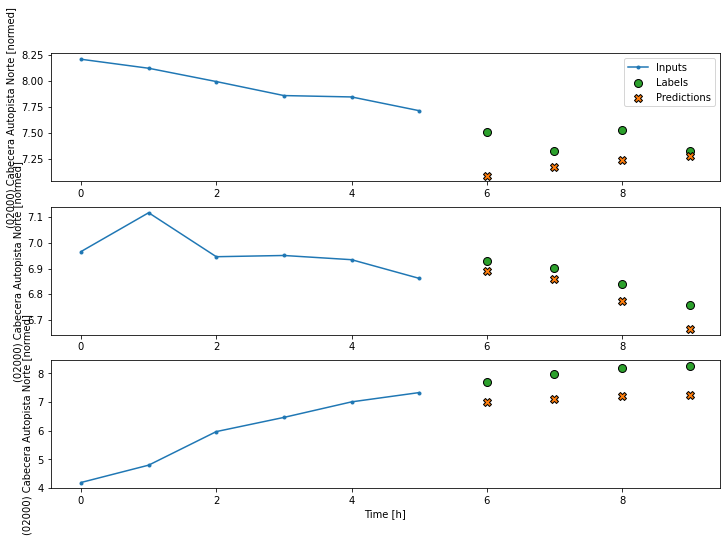

In [ ]:
## Accession resutls 
####################
a = results['(02000) Cabecera Autopista Norte']

### Results description 
# a[0] = train model 
# a[1] = time-windowed data
# a[2] = trained neural network 

## For evaluation 
## b = a[2].evaluate(a[1].test)
# b[0] = loss function 
# b[1] = MAE Remember than for 15-mins prediction we can't use MAPE because many values are zeros. MAPE is undifened when this happens. 
# b[2] = RMSE

a[2].evaluate(a[1].test)
a[2].predict(a[1].test)
a[1].plot(a[2])

In [ ]:
#########################
## Preliminary resutls ##
#########################

pre = pd.DataFrame(rmse_pre).T
pre.columns = ['loss', 'MAE', 'RMSE']
pre['covid'] = 'Pre-covid'
post = pd.DataFrame(rmse_post).T
post.columns = ['loss', 'MAE', 'RMSE']
post['covid'] = 'Post-covid'

final_results = pd.concat((pre, post))
sns.histplot(data = final_results, x = 'RMSE', hue = 'covid')

### Random code 
This code was used to make some experiements to verify certain functionalities of the final code. 

In [ ]:
col_name = '(02000) Cabecera Autopista Norte'
w1 = WindowGenerator(input_width=6, label_width=1, shift=1, 
                     train_df=train_df[[col_name]], test_df=test_df[[col_name]], covid_df=covid_df[[col_name]],
                     label_columns=['(02000) Cabecera Autopista Norte'])
w1

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['(02000) Cabecera Autopista Norte']

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size][[col_name]]),
                           np.array(train_df[100:100+w1.total_window_size][[col_name]]),
                           np.array(train_df[200:200+w1.total_window_size][[col_name]])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
labels shape: (3, 1, 1)


In [ ]:
w1.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

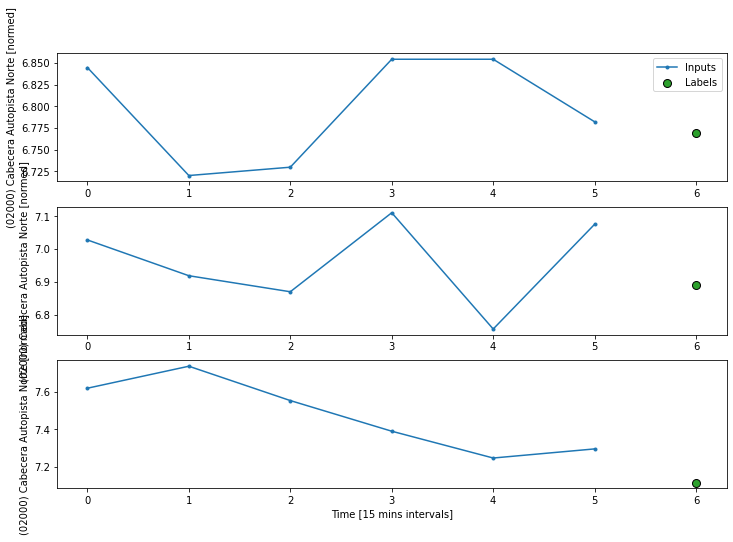

In [ ]:
w1.plot(xlabel = 'Time [15 mins intervals]')

In [ ]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (128, 6, 1)
Labels shape (batch, time, features): (128, 1, 1)


## Dense neural Network 

In [ ]:
MAX_EPOCHS = 20

## This compalies and fit any model in general 
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                         tf.metrics.RootMeanSquaredError()]) ## this is where I could potentially change the metric 

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.test,
                      callbacks=[early_stopping])
  return history

In [ ]:
conv_window = WindowGenerator(input_width=6, 
                              label_width=1, 
                              shift=1,
                              train_df=train_df[[col_name]], 
                              test_df=test_df[[col_name]], 
                              covid_df=covid_df[[col_name]],
                              label_columns=['(02000) Cabecera Autopista Norte'])

In [ ]:
input_width=6
label_width=1
shift=1

one_window = WindowGenerator(input_width=6, 
                              label_width=1, 
                              shift=1,
                              train_df=train_df[[col_name]], 
                              test_df=test_df[[col_name]], 
                              covid_df=covid_df[[col_name]],
                              label_columns=['(02000) Cabecera Autopista Norte'])

units_layer = int(0.5*(input_width + shift))

one_prediction = tf.keras.Sequential([
    tf.keras.layers.Flatten(),#Input layaer
    tf.keras.layers.Dense(units=units_layer, activation='sigmoid'),#Hidden layer
    tf.keras.layers.Dense(units=shift),#Output layer
    tf.keras.layers.Reshape([1, -1]),
])





In [ ]:
print('Input shape:', one_window.example[0].shape)
print('Output shape:', one_prediction(one_window.example[0]).shape)

Input shape: (128, 6, 1)
Output shape: (128, 1, 1)


In [ ]:
history = compile_and_fit(one_prediction, one_window)

# pre_covid_performance = {}
# post_covid_performance = {}

# IPython.display.clear_output()
# pre_covid_performance[station_name] = multi_step_dense.evaluate(conv_window.val)
# post_covid_performance[station_name] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
990/990 [==============================] - 6s 5ms/step - loss: 14.2143 - mean_absolute_error: 3.3972 - root_mean_squared_error: 3.7702 - val_loss: 5.0449 - val_mean_absolute_error: 2.1121 - val_root_mean_squared_error: 2.2461
Epoch 2/20
990/990 [==============================] - 5s 5ms/step - loss: 2.8804 - mean_absolute_error: 1.5089 - root_mean_squared_error: 1.6972 - val_loss: 1.5262 - val_mean_absolute_error: 0.9703 - val_root_mean_squared_error: 1.2354
Epoch 3/20
990/990 [==============================] - 6s 6ms/step - loss: 0.9648 - mean_absolute_error: 0.7198 - root_mean_squared_error: 0.9823 - val_loss: 0.9437 - val_mean_absolute_error: 0.5663 - val_root_mean_squared_error: 0.9715
Epoch 4/20
990/990 [==============================] - 6s 6ms/step - loss: 0.6428 - mean_absolute_error: 0.5018 - root_mean_squared_error: 0.8018 - val_loss: 0.8182 - val_mean_absolute_error: 0.4795 - val_root_mean_squared_error: 0.9046
Epoch 5/20
990/990 [==============================] - 6

In [ ]:
test_resutls = one_prediction.evaluate(one_window.test)
print ('Mean square error test: {0:.2f}'.format(test_resutls[0]))
print ('MAE test: {0:.2f}'.format(test_resutls[1]))
print ('RMSE test: {0:.2f}'.format(test_resutls[2]))

181/181 [==============================] - 1s 4ms/step - loss: 0.5091 - mean_absolute_error: 0.3342 - root_mean_squared_error: 0.7135
Mean square error test: 0.51
MAE test: 0.33
RMSE test: 0.71


In [ ]:
covid_resutls = one_prediction.evaluate(one_window.covid, verbose=0)
print ('Mean square error COVID: {0:.2f}'.format(covid_resutls[0]))
print ('MAE COVID: {0:.2f}'.format(covid_resutls[1]))
print ('RMSE COVID: {0:.2f}'.format(covid_resutls[2]))

Mean square error COVID: 0.54
MAE COVID: 0.43
RMSE COVID: 0.74


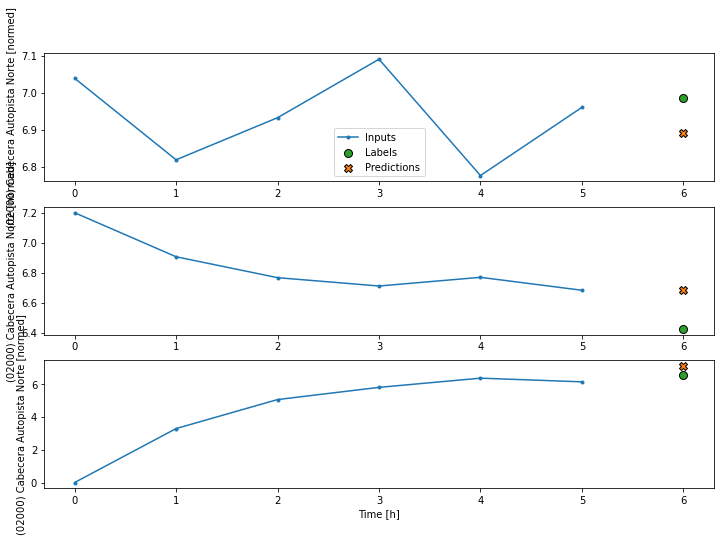

In [ ]:
one_window.plot(one_prediction)

In [ ]:
prediction = multi_step_dense.predict(conv_window.test)
prediction = prediction.reshape(1, -1)

In [ ]:
prediction.shape

In [ ]:
################
################
## MORE THAN 1 #
## STEP AHEAD ##
################
################
input_width=6
label_width=4
shift= 4
num_features = 2
col_names = ['(02000) Cabecera Autopista Norte', '(02001) Centro Comercial Santa Fe']

four_window = WindowGenerator(input_width=input_width, 
                              label_width=label_width, 
                              shift=shift,
                              train_df=train_df[col_names], 
                              test_df=test_df[col_names], 
                              covid_df=covid_df[col_names],
                              label_columns=['(02000) Cabecera Autopista Norte'])

units_layer = int(0.5*(input_width + shift))

four_prediction = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(units_layer, activation='sigmoid'),
    # Shape => [batch, 1, out_step]
    tf.keras.layers.Dense(shift),
    # Shape => [batch, out_steps, 1]
    tf.keras.layers.Reshape([shift, -1])
])

In [ ]:
history = compile_and_fit(four_prediction, four_window)

Epoch 1/20
990/990 [==============================] - 5s 5ms/step - loss: 16.9127 - mean_absolute_error: 3.6763 - root_mean_squared_error: 4.1125 - val_loss: 5.8694 - val_mean_absolute_error: 2.2341 - val_root_mean_squared_error: 2.4227
Epoch 2/20
990/990 [==============================] - 5s 5ms/step - loss: 3.7111 - mean_absolute_error: 1.6041 - root_mean_squared_error: 1.9264 - val_loss: 2.6651 - val_mean_absolute_error: 1.1719 - val_root_mean_squared_error: 1.6325
Epoch 3/20
990/990 [==============================] - 5s 5ms/step - loss: 2.1674 - mean_absolute_error: 1.0365 - root_mean_squared_error: 1.4722 - val_loss: 2.0707 - val_mean_absolute_error: 0.9368 - val_root_mean_squared_error: 1.4390
Epoch 4/20
990/990 [==============================] - 5s 5ms/step - loss: 1.7309 - mean_absolute_error: 0.8537 - root_mean_squared_error: 1.3156 - val_loss: 1.8111 - val_mean_absolute_error: 0.8001 - val_root_mean_squared_error: 1.3458
Epoch 5/20
990/990 [==============================] - 6

In [ ]:
prediction = four_prediction.predict(four_window.test)

In [ ]:
prediction

array([[[6.7927265],
        [6.715681 ],
        [6.627729 ],
        [6.5502677]],

       [[7.258005 ],
        [7.3653183],
        [7.3322244],
        [7.359115 ]],

       [[0.5690728],
        [0.7520761],
        [1.0477042],
        [1.3804818]],

       ...,

       [[1.4451423],
        [1.5537465],
        [1.7703068],
        [2.017415 ]],

       [[6.7468414],
        [6.6799264],
        [6.595074 ],
        [6.5256853]],

       [[6.8937726],
        [6.86826  ],
        [6.7943816],
        [6.749337 ]]], dtype=float32)

In [ ]:
test_resutls = four_prediction.evaluate(four_window.test)
print ('Mean square error test: {0:.2f}'.format(test_resutls[0]))
print ('MAE test: {0:.2f}'.format(test_resutls[1]))
print ('RMSE test: {0:.2f}'.format(test_resutls[2]))

181/181 [==============================] - 1s 4ms/step - loss: 1.5838 - mean_absolute_error: 0.6454 - root_mean_squared_error: 1.2585
Mean square error test: 1.58
MAE test: 0.65
RMSE test: 1.26


In [ ]:
covid_resutls = four_prediction.evaluate(four_window.covid, verbose=0)
print ('Mean square error COVID: {0:.2f}'.format(covid_resutls[0]))
print ('MAE COVID: {0:.2f}'.format(covid_resutls[1]))
print ('RMSE COVID: {0:.2f}'.format(covid_resutls[2]))

Mean square error COVID: 1.27
MAE COVID: 0.70
RMSE COVID: 1.13


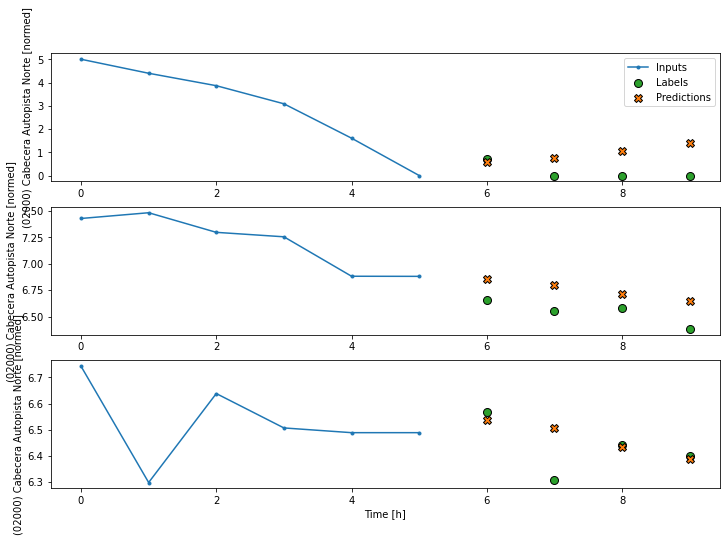

In [ ]:
four_window.plot(four_prediction)

In [ ]:
def nn_model(input_width=6, label_width=4, shift= 4, num_features = 1, 
             train_df = train, test_df = test, covid_df = covid, column = '(02000) Cabecera Autopista Norte'):

    ## Create windowing:
    window = WindowGenerator(input_width=input_width, 
                              label_width=label_width, 
                              shift=shift,
                              train_df=train_df, 
                              test_df=test_df, 
                              covid_df=covid_df,
                              label_columns=[column])

    units_layer = int(0.5*(input_width + shift))
    ## Create neural network structure: 
    if shift == 1: 
        neural_net = tf.keras.Sequential([
            tf.keras.layers.Flatten(),#Input layaer
            tf.keras.layers.Dense(units=units_layer, activation='sigmoid'),#Hidden layer
            tf.keras.layers.Dense(units=shift),#Output layer
            tf.keras.layers.Reshape([1, -1]),
            ])
    elif shift > 1: 
        neural_net = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, 1, features]
            tf.keras.layers.Lambda(lambda x: x[:, -1:, :]), #input Layer
            # Shape => [batch, 1, dense_units]
            tf.keras.layers.Dense(units_layer, activation='sigmoid'), # Hidden layer
            # Shape => [batch, 1, out_step]
            tf.keras.layers.Dense(shift), # Output Layer
            # Shape => [batch, out_steps, 1]
            tf.keras.layers.Reshape([shift, -1])
            ])
    else:
        raise "Predicte time steps should be a positive integer number"


    model = compile_and_fit(neural_net, window)
    return model, window, neural_net

In [ ]:
input_width=6
label_width=4
shift= 4
col_names = ['(02000) Cabecera Autopista Norte', 'day', 'hour', 'weekday']


model_four, window_four, neural_net = nn_model(input_width=input_width, label_width=label_width, shift= shift, num_features = 1, 
         train_df = train_df[col_names], test_df = test_df[col_names], covid_df = covid_df[col_names], 
         column = '(02000) Cabecera Autopista Norte')

Epoch 1/20
990/990 [==============================] - 6s 6ms/step - loss: 23.4777 - mean_absolute_error: 4.4478 - root_mean_squared_error: 4.8454 - val_loss: 12.4105 - val_mean_absolute_error: 3.3227 - val_root_mean_squared_error: 3.5229
Epoch 2/20
990/990 [==============================] - 6s 6ms/step - loss: 8.1547 - mean_absolute_error: 2.6577 - root_mean_squared_error: 2.8556 - val_loss: 4.5212 - val_mean_absolute_error: 1.9451 - val_root_mean_squared_error: 2.1263
Epoch 3/20
990/990 [==============================] - 5s 5ms/step - loss: 3.1325 - mean_absolute_error: 1.5266 - root_mean_squared_error: 1.7699 - val_loss: 2.1887 - val_mean_absolute_error: 1.1215 - val_root_mean_squared_error: 1.4794
Epoch 4/20
990/990 [==============================] - 5s 5ms/step - loss: 1.6358 - mean_absolute_error: 0.9181 - root_mean_squared_error: 1.2790 - val_loss: 1.5504 - val_mean_absolute_error: 0.7609 - val_root_mean_squared_error: 1.2452
Epoch 5/20
990/990 [==============================] - 

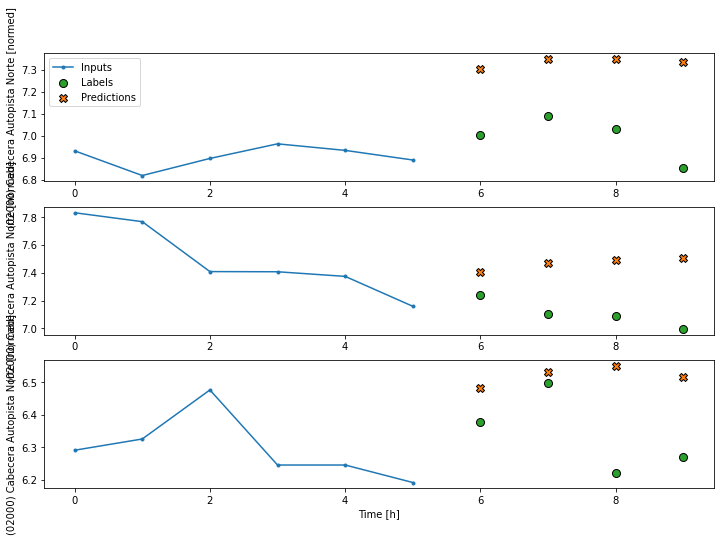

In [ ]:
window_four.plot(neural_net)

In [ ]:
neural_net.evaluate(window_four.test)

181/181 [==============================] - 1s 4ms/step - loss: 1.0100 - mean_absolute_error: 0.5035 - root_mean_squared_error: 1.0050


[1.0100150108337402, 0.5034856796264648, 1.0049949884414673]

In [ ]:
neural_net.evaluate(window_four.covid)

286/286 [==============================] - 1s 5ms/step - loss: 1.3088 - mean_absolute_error: 0.8067 - root_mean_squared_error: 1.1440


[1.3087908029556274, 0.8066955804824829, 1.1440238952636719]

### Resutls for all stations and all posible time steps 

In [ ]:
station_cols[:5]

Index(['(02000) Cabecera Autopista Norte', '(02001) Centro Comercial Santa Fe',
       '(02101) Toberín', '(02102) Calle 161', '(02103) Mazurén'],
      dtype='object')

In [ ]:
rmse_pre = {}
rmse_post = {}
times = {}
counter = 1
for station in station_cols[:5]:

    start = time.time()
    print ('Station: ', counter)


    input_width=6
    label_width=4
    shift= 4
    col_names = [station, 'day', 'hour', 'weekday']


    model_four, window_four, neural_net = nn_model(input_width=input_width, label_width=label_width, 
                                                   shift=shift, num_features = 1, train_df = train_df[col_names],
                                                   test_df = test_df[col_names], covid_df = covid_df[col_names], 
                                                   column = station)

    rmse_pre[station] = neural_net.evaluate(window_four.test)
    rmse_post[station] = neural_net.evaluate(window_four.covid)

    
    end = time.time()
    times[station] = end - start
    counter +=1
    IPython.display.clear_output()

In [ ]:
pre = pd.DataFrame(rmse_pre).T
pre.columns = ['loss', 'MAE', 'RMSE']
pre['covid'] = 'Pre-covid'
post = pd.DataFrame(rmse_post).T
post.columns = ['loss', 'MAE', 'RMSE']
post['covid'] = 'Post-covid'

final_results = pd.concat((pre, post))
sns.histplot(data = final_results, x = 'RMSE', hue = 'covid')

<AxesSubplot:xlabel='RMSE', ylabel='Count'>

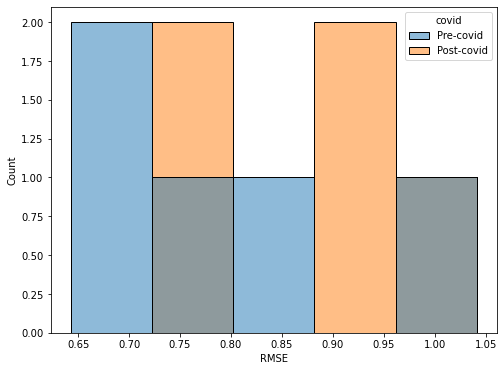

In [ ]:
final_results = pd.concat((pre, post))
sns.histplot(data = final_results, x = 'RMSE', hue = 'covid')

(array([2., 0., 0., 1., 0., 0., 1., 0., 0., 1.]),
 array([0.64284861, 0.67622333, 0.70959805, 0.74297277, 0.77634749,
        0.80972221, 0.84309694, 0.87647166, 0.90984638, 0.9432211 ,
        0.97659582]),
 <BarContainer object of 10 artists>)

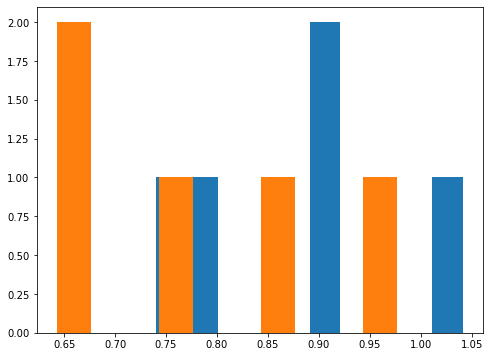

In [ ]:
plt.hist(post.RMSE)
plt.hist(pre.RMSE)

## Recurrent Neural Network - LSTM

In [ ]:
wide_window = WindowGenerator(input_width=24, 
                              label_width=24, 
                              shift=1,
                              train_df=train_df[[col_name]], 
                              val_df=val_df[[col_name]], 
                              test_df=test_df[[col_name]],
                              label_columns=['(02000) Cabecera Autopista Norte'])

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

1165/1165 [==============================] - 3s 3ms/step - loss: 0.3614 - mean_absolute_error: 0.2974


In [ ]:
## TO DO
Code seems to be working for RNN and 

In [ ]:
import orca
orca.add_injectable("test", True)
test_injectable = 'test' in orca.list_injectables()
if test_injectable:
    print ("it works")
else:
    print ("not working")

it works


In [ ]:
orca.list_injectables()

['test']